In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import tensorflow as tf
import numpy as np

from architectures.fc_models import ResidualAutoEncoder
from helpers.data import load_keras_dataset
from metrics.psnr_hvs import compute_psnr_hvs

# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras.optimizers.schedules import ExponentialDecay

tf.config.run_functions_eagerly(True)

2024-04-03 23:50:27.805505: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 23:50:27.841875: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 23:50:28.786877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/cezar/anaconda3/envs/disertatie/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as not

PyTorch not installed, if you wish to use PyTorch, install as psnr_hvsm[torch]:
$> pip install psnr_hvsm[torch]


In [5]:
from tensorflow_datasets.core.utils import gcs_utils
gcs_utils._is_gcs_disabled = True

import tensorflow_datasets as tfds
stl10 = tfds.load('stl10', split='train', shuffle_files=False, try_gcs=False)

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:   0%|          | 0/1 [00:44<?, ? url/s]
Extraction completed...: 0 file [00:48, ? file/s]
Dl Completed...:   0%|          | 0/1 [00:48<?, ? url/s]


KeyboardInterrupt: 

In [2]:
BINARY_SIZE = 32
PATCH_SIZE = 8
STEPS = 16

In [3]:
network = ResidualAutoEncoder(binary_size=BINARY_SIZE, patch_size=PATCH_SIZE, steps=STEPS)

2024-04-03 23:50:30.603798: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 23:50:30.657844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 23:50:30.657884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 23:50:30.659847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 23:50:30.659879: I tensorflow/compile

In [4]:
# # load the model
# network(tf.random.normal((1, PATCH_SIZE *PATCH_SIZE *3)))
# network.load_weights('residual_autoencoder_fully_connected_512.h5')  

In [5]:
def load_dataset(dataset_name):
    import keras.datasets as datasets
    (x_train, _), (x_test, _) = getattr(datasets, dataset_name).load_data()

    x_train = np.append(x_train, x_test, axis=0)
    x_train = x_train.astype('float32') / 127.5 - 1
    return x_train

def get_data():
    cifar10_dataset = load_dataset('cifar10')
    cifar100_dataset = load_dataset('cifar100')

    # append the datasets
    dataset = np.append(cifar10_dataset, cifar100_dataset, axis=0)

    return dataset

def get_simple_data():
    cifar10_dataset = load_dataset('cifar10')

    return cifar10_dataset

In [6]:
dataset = get_simple_data()

In [7]:
dataset = tf.image.extract_patches(dataset, sizes=[1, PATCH_SIZE, PATCH_SIZE, 1], strides=[1, PATCH_SIZE, PATCH_SIZE, 1], rates=[1, 1, 1, 1], padding='VALID')

In [8]:
# flatten the data
dataset = tf.reshape(dataset, [-1, PATCH_SIZE*PATCH_SIZE*3])

In [9]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True)
optimizer = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
network.compile(optimizer=optimizer, loss='mse')

In [42]:
tf.config.run_functions_eagerly(False)
network.fit(dataset, dataset, epochs=5, shuffle=True, batch_size=128)

Epoch 1/5
   2/7500 [..............................] - ETA: 6:41 - loss: 0.6148

7500/7500 [==============================] - 251s 34ms/step - loss: 0.3427
Epoch 2/5
7500/7500 [==============================] - 257s 34ms/step - loss: 0.2110
Epoch 3/5
7500/7500 [==============================] - 250s 33ms/step - loss: 0.2316
Epoch 4/5
7500/7500 [==============================] - 258s 34ms/step - loss: 0.1915
Epoch 5/5
7500/7500 [==============================] - 241s 32ms/step - loss: 41.7565


In [43]:
tf.keras.utils.plot_model(network.build_graph(), show_shapes=True, dpi=64, expand_nested=True, show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [44]:
network.summary()

Model: "residual_auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           (None, 32)                267136    
                                                                 
 encoder_1 (Encoder)         (None, 32)                267136    
                                                                 
 encoder_2 (Encoder)         (None, 32)                267136    
                                                                 
 encoder_3 (Encoder)         (None, 32)                267136    
                                                                 
 encoder_4 (Encoder)         (None, 32)                267136    
                                                                 
 encoder_5 (Encoder)         (None, 32)                267136    
                                                                 
 encoder_6 (Encoder)         (None, 32)      

1/1 [==============================] - 0s 34ms/step


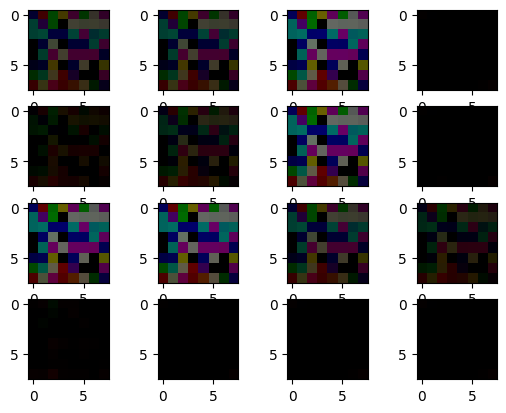

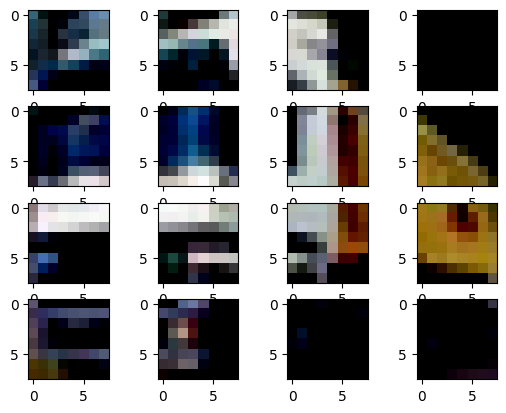

In [58]:
output = np.zeros((PATCH_SIZE, PATCH_SIZE, 3))
input_patch = dataset[16:32]

output = network.predict(input_patch)

import matplotlib.pyplot as plt

# display a 4x4 grid of images
fig, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(np.clip(output[i * 4 + j] ,0 ,1).reshape(PATCH_SIZE, PATCH_SIZE, 3))

plt.show()

fig, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(np.clip(input_patch[i * 4 + j], 0, 1).reshape(PATCH_SIZE, PATCH_SIZE, 3))

In [60]:
patches = []
input_value = dataset[5:6]
for i in range(STEPS):
    input_layer = tf.keras.layers.Input(shape=(PATCH_SIZE * PATCH_SIZE * 3,))
    encoder = tf.keras.models.Model(inputs=input_layer, outputs=network.encoders[i].call(input_layer))

    bits = encoder.predict(input_value)

    input_layer = tf.keras.layers.Input(shape=(BINARY_SIZE,))
    decoder = tf.keras.models.Model(inputs=input_layer, outputs=network.decoders[i].call(input_layer))

    output = decoder.predict(bits)
    patches.append(output)

    input_value = input_value - output

patches = np.array(patches).reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)

1/1 [==============================] - 0s 44ms/step


In [61]:
patches_copy = patches.copy()

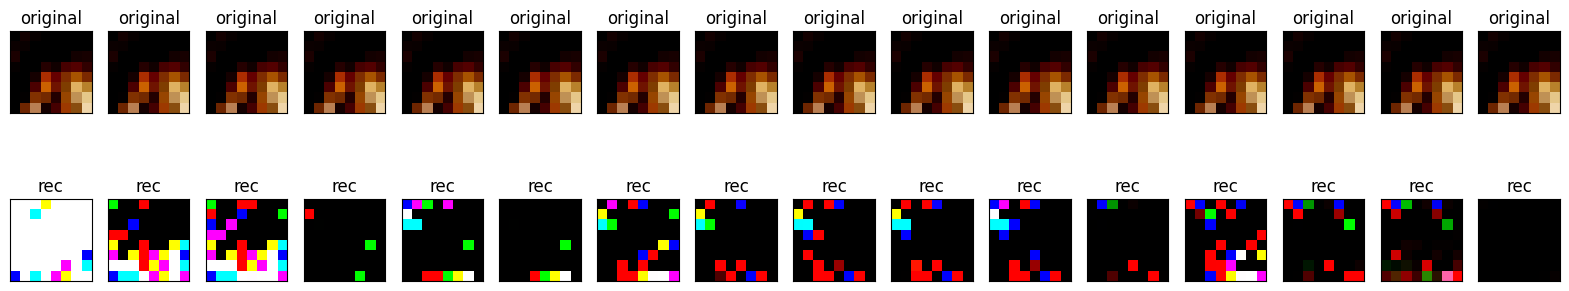

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
reconstructed = np.zeros((PATCH_SIZE, PATCH_SIZE, 3))

for i in range(STEPS):
    # display original
    ax = plt.subplot(2, STEPS, i + 1)
    plt.imshow(np.clip(dataset[5], 0, 1).reshape(PATCH_SIZE, PATCH_SIZE, 3))
    plt.title("original")
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, STEPS, i + 1 + STEPS)

    reconstructed = patches_copy[i] + reconstructed
    plt.imshow(np.clip(reconstructed, 0, 1))
    plt.title("rec")
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [49]:
# save network to disk
network.save_weights('residual_autoencoder_fully_connected_32.h5')

In [50]:
def pad_image(image: np.ndarray, patch_size: int):
    h, w, c = image.shape
    h_pad = (patch_size - (h % patch_size)) % patch_size
    w_pad = (patch_size - (w % patch_size)) % patch_size

    return np.pad(image, ((0, h_pad), (0, w_pad), (0, 0)), mode='constant', constant_values=0), h_pad, w_pad

In [51]:
def compress_image(image: np.ndarray, network: tf.keras.Model) -> tuple[np.ndarray, np.ndarray]:
    """
    Compress an image using the given network
    :param image: The image to compress
    :param network: The network to use for compression
    :return: The compressed image & the bits
    """
    patch_size = network.patch_size
    steps = network.steps

    print(image.shape)

    # pad the image
    image, h_pad, w_pad = pad_image(image, patch_size)
    
    print(image.shape)
    height, width, channels = image.shape
    no_patches_width = width // patch_size
    no_patches_height = height // patch_size
    
    # transform image to list with a single element
    image = tf.expand_dims(image, axis=0)

    image = tf.image.extract_patches(image, sizes=[1, patch_size, patch_size, 1], strides=[1, patch_size, patch_size, 1], rates=[1, 1, 1, 1], padding='VALID')
    image = tf.divide(tf.cast(image, tf.float32), 127.5) - 1
    image = tf.reshape(image, [-1, patch_size*patch_size*3])

    bits = []
    reconstructed_patches = []

    input_value = image
    for i in range(steps):
        input_layer = tf.keras.layers.Input(shape=(patch_size * patch_size * 3,))
        encoder = tf.keras.models.Model(inputs=input_layer, outputs=network.encoders[i].call(input_layer))

        bits.append(encoder.predict(input_value))

        input_layer = tf.keras.layers.Input(shape=(network.binary_size,))
        decoder = tf.keras.models.Model(inputs=input_layer, outputs=network.decoders[i].call(input_layer))

        output = decoder.predict(bits[i])
        input_value = input_value - output

    reconstructed_patches = network.predict(image)
    
    reconstructed_image = np.zeros((height, width, channels))
    for i in range(no_patches_height):
        for j in range(no_patches_width):
            patch = reconstructed_patches[i*no_patches_width+j].reshape(patch_size, patch_size, 3)
            print(i*patch_size, (i+1)*patch_size, j*patch_size, (j+1)*patch_size)
            reconstructed_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patch

    height = height - h_pad
    width = width - w_pad

    reconstructed_image = reconstructed_image[:height, :width]
    
    return reconstructed_image

In [63]:
# load an image
from PIL import Image

image = Image.open('ciob.png').convert('RGB')
image = np.array(image)


In [64]:
compressed = compress_image(image, network)

(467, 396, 3)
(472, 400, 3)
93/93 [==============================] - 1s 9ms/step
0 8 0 8
0 8 8 16
0 8 16 24
0 8 24 32
0 8 32 40
0 8 40 48
0 8 48 56
0 8 56 64
0 8 64 72
0 8 72 80
0 8 80 88
0 8 88 96
0 8 96 104
0 8 104 112
0 8 112 120
0 8 120 128
0 8 128 136
0 8 136 144
0 8 144 152
0 8 152 160
0 8 160 168
0 8 168 176
0 8 176 184
0 8 184 192
0 8 192 200
0 8 200 208
0 8 208 216
0 8 216 224
0 8 224 232
0 8 232 240
0 8 240 248
0 8 248 256
0 8 256 264
0 8 264 272
0 8 272 280
0 8 280 288
0 8 288 296
0 8 296 304
0 8 304 312
0 8 312 320
0 8 320 328
0 8 328 336
0 8 336 344
0 8 344 352
0 8 352 360
0 8 360 368
0 8 368 376
0 8 376 384
0 8 384 392
0 8 392 400
8 16 0 8
8 16 8 16
8 16 16 24
8 16 24 32
8 16 32 40
8 16 40 48
8 16 48 56
8 16 56 64
8 16 64 72
8 16 72 80
8 16 80 88
8 16 88 96
8 16 96 104
8 16 104 112
8 16 112 120
8 16 120 128
8 16 128 136
8 16 136 144
8 16 144 152
8 16 152 160
8 16 160 168
8 16 168 176
8 16 176 184
8 16 184 192
8 16 192 200
8 16 200 208
8 16 208 216
8 16 216 224
8 16 224 23

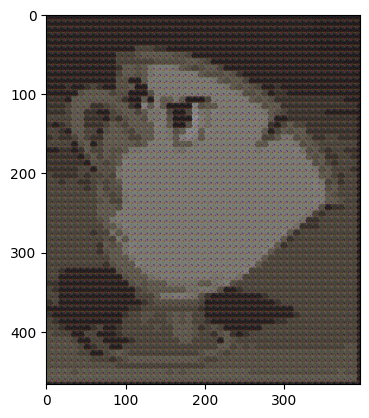

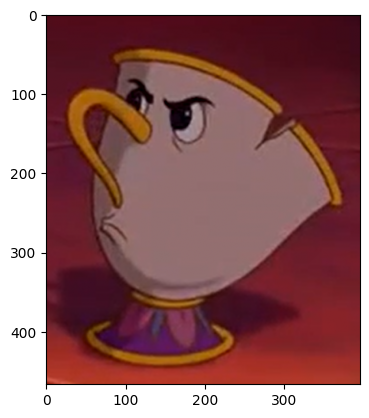

In [66]:
compressed_copy = np.clip((compressed + 1) / 2, 0 ,1)
plt.imshow(compressed_copy)
plt.show()

plt.imshow(image / 255)
plt.show()


In [67]:
compressed_padded, _, _ = pad_image(compressed_copy, PATCH_SIZE)
image_padded, _, _ = pad_image(image, PATCH_SIZE)

In [72]:
from metrics import psnr_hvs
psnr_hvs_val = psnr_hvs.compute_psnr_hvs((image_padded/ 255).reshape(-1, *image_padded.shape), compressed_padded.reshape(-1, *compressed_padded.shape))

(1, 472, 400)


In [73]:
psnr_hvs_val

array([72.95950488])